# Noise Calculation

We saw in the [Noise Addition](NoiseAddition.ipynb) notebook that two signals comprised of measurements that are sampled from a normally distributed source with some specified standard deviation add in the context of power rather than the measurement values directly added.  Now we will look at how we can back-figure the device under test noise from the total noise of the system.  The presumption for the noises here are the same as from the other notebook.  It is useful to note that not all of the graphical representations of the noise presented here make sense in practice; you would not have access to the signal representing the device under test alone.

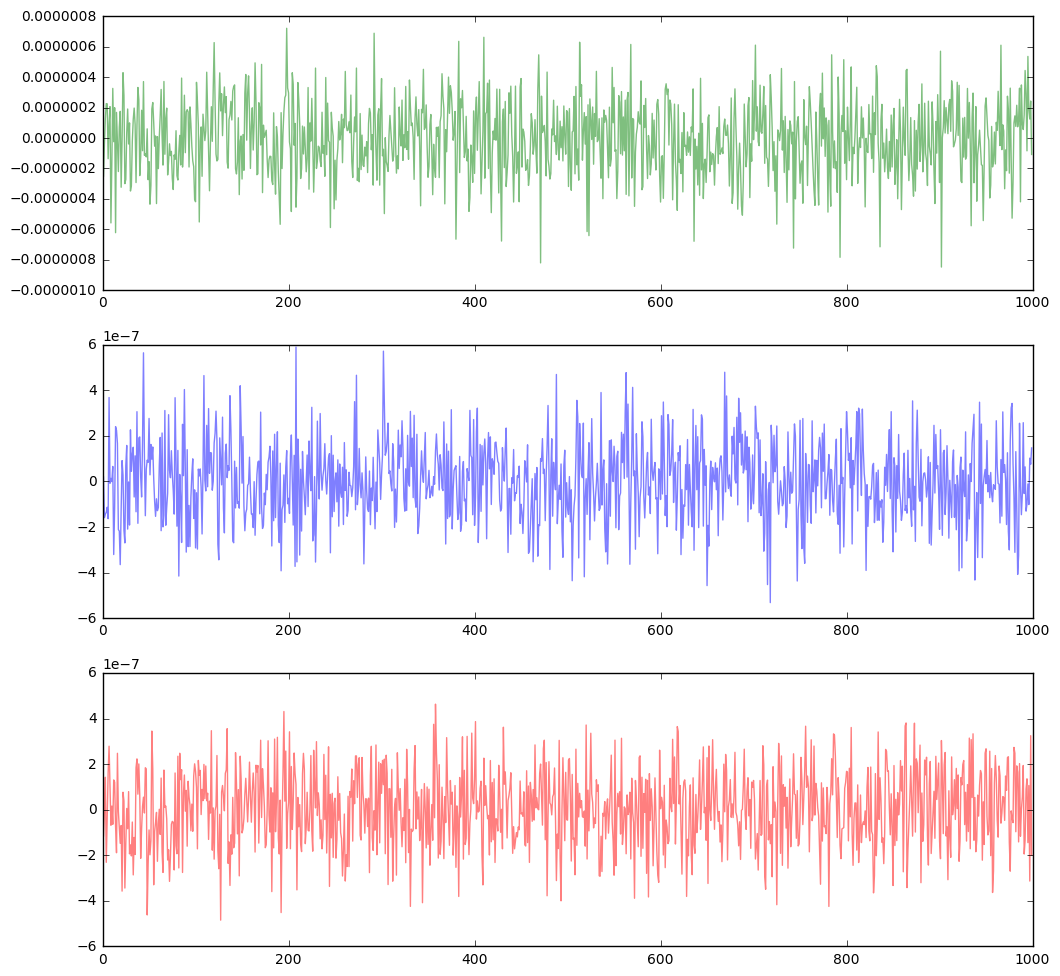

DUT noise (RMS): 1.71083810154e-07


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,12))

# Total system noise (total amplifier noise plus device under test noise = 250nV)
n1 = [np.random.normal(0, 2.5e-7) for i in range(1000)]
plt.subplot(3, 1, 1)
plt.plot(n1, color='g', alpha=0.5)
rms1 = np.std(n1)

# Amplifier noise (op-amp plus input resistance thermal noise = 175nV)
n2 = [np.random.normal(0, 1.75e-7) for i in range(1000)]
plt.subplot(3, 1, 2)
plt.plot(n2, color='b', alpha=0.5)
rms2 = np.std(n2)

# Compute the device under test residual noise
rms3 = math.sqrt(rms1**2 - rms2**2)

# Plot the resulting DUT noise (could not do this in practice)
n3 = [np.random.normal(0, rms3) for i in range(1000)]
plt.subplot(3, 1, 3)
plt.plot(n3, color='r', alpha=0.5)

# Display the plot
plt.show()

# Indicate the resulting DUT noise
print("DUT noise (RMS): " + str(rms3))


As you can see, we can easily determine what the device under test noise would have had to be in order for the power sum to work out.  Notice that the power sum works properly only because we have two *uncorrelated* signals.  In this next section we will work this problem backwards with the assumption that the device under test has a signal that does not fall into this assumption mixed in to it.  We will see that the output is not what we expect.

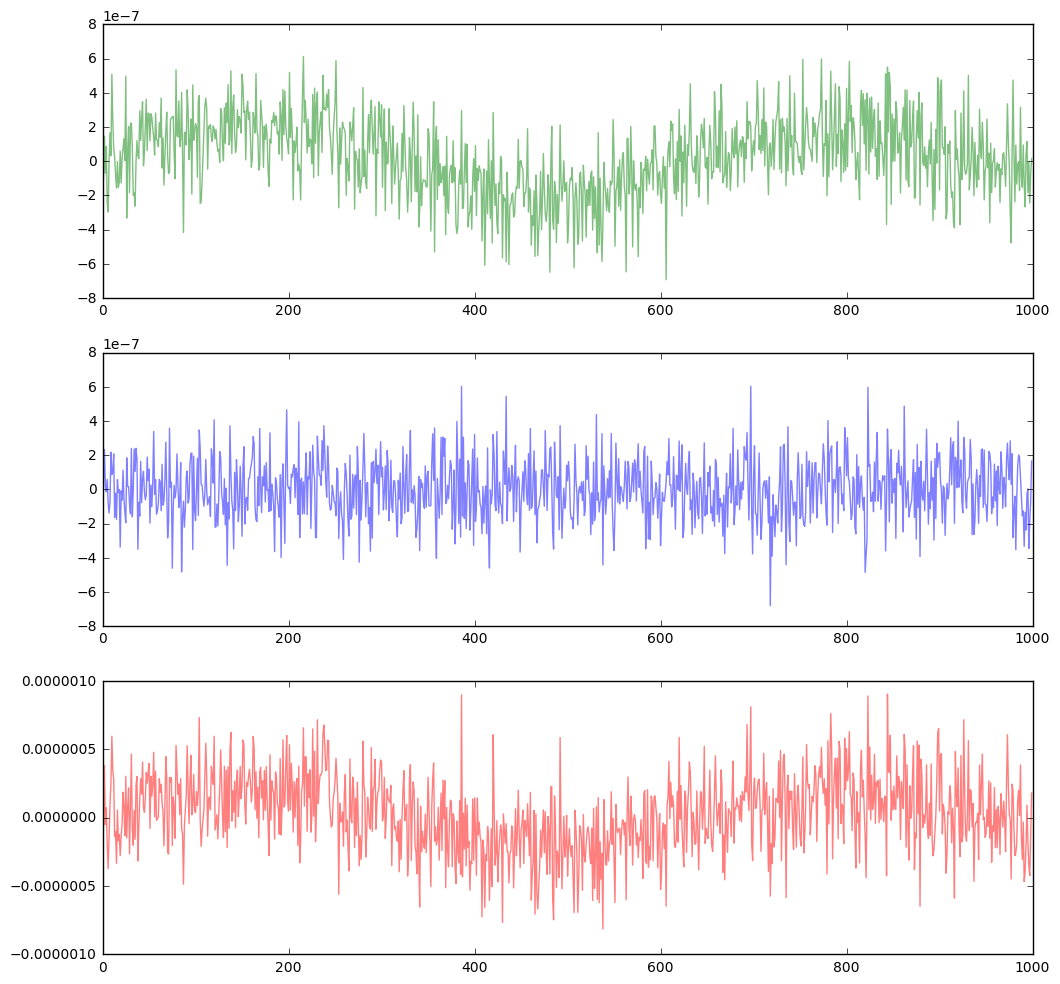

RMS 1: 1.8e-07
RMS 2: 1.74995730946e-07
RMS 3: 2.82498249373e-07 (from data)
RMS 3: 2.51044828366e-07 (computed)


In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,12))

# DUT noise (180nV normally distributed noise plus periodic signal)
n1 = [np.random.normal(0, 1.8e-7) + 2.0e-7 * math.sin(float(i) / 100) for i in range(1000)]
plt.subplot(3, 1, 1)
plt.plot(n1, color='g', alpha=0.5)
rms1 = 1.8e-7

# Amplifier noise (op-amp plus input resistance thermal noise = 175nV)
n2 = [np.random.normal(0, 1.75e-7) for i in range(1000)]
plt.subplot(3, 1, 2)
plt.plot(n2, color='b', alpha=0.5)
rms2 = np.std(n2)

# Total system noise
n3 = [n1[i] + n2[i] for i in range(1000)]
plt.subplot(3, 1, 3)
plt.plot(n3, color='r', alpha=0.5)
rms3 = np.std(n3)

# Plot the various noises
plt.show()

# Compute the RMS noise (as opposed to add our two sampled measurements pointwise)
rms4 = math.sqrt(rms1**2 + rms2**2)

# Print the computed RMS values
print("RMS 1: " + str(rms1))
print("RMS 2: " + str(rms2))
print("RMS 3: " + str(rms3) + " (from data)")
print("RMS 3: " + str(rms4) + " (computed)")

Obvious underlying *correlated* signal! As you can see, the "RMS 1" figure in this case is set to the known noise.  When we add this in the power sense to the amplifier noise, we end up with a computed value that is inconsistent with the measured RMS noise.  It is a philosophical debate whether this additional environmental noise would be included on our specification sheet or not for the device under test, as it is a question of whether or not the end user would experience it or is it simply a byproduct of our measurement.  Often you would be able to determine this through other testing.  For our purposes here we will presume that the noise is measurement related and not the device under test noise.  That said, we need to determine how to estimate the underlying signal magnitude so that we can remove it from our measurement.  

There are two dominant ways of recovering a signal such as this underlying sinusoid. First, you could use a frequency selective mechanism.  There are a wide range of test instruments based around this approach, like lock-in amplifiers.  These instruments are designed to recover minute signals in enormous amounts of noise.  The other approach is to note that uncorrelated noise adds more slowly than correlated noise, and simply perform averaging to better estimate the underlying correlated signal.  This is the approach that a sampling scope uses, and since that is what we are presuming about our test best, that is what we will mimic here.  Other techniques, such as Kalman filtering, could be used to further estimate the underlying signal, but we will only look at the averaging.

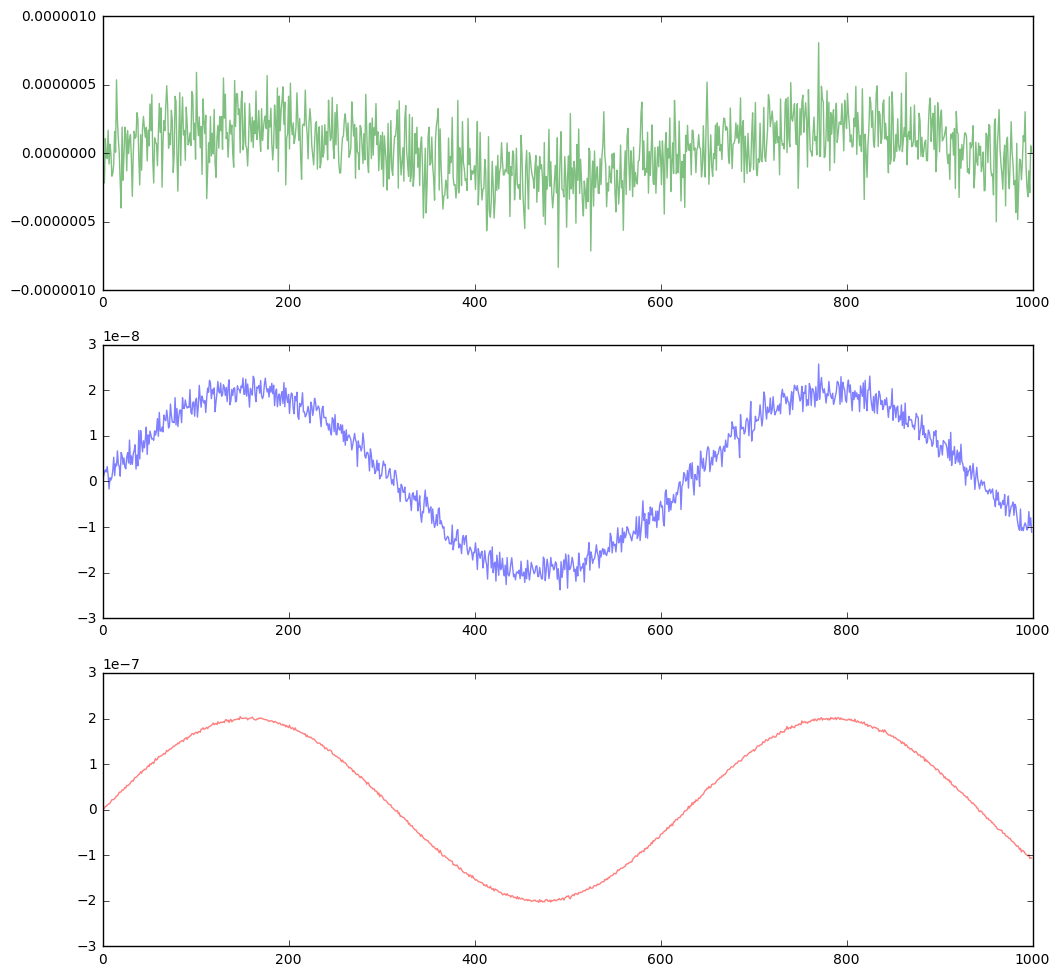

RMS (correlated): 1.33241231767e-07


In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,12))

# Plot one run of the sampled data
n1 = [np.random.normal(0, 1.8e-7) + 2.0e-7 * math.sin(float(i) / 100) for i in range(1000)]
plt.subplot(3, 1, 1)
plt.plot(n1, color='g', alpha=0.5)

# Plot 100 averages of the sampled data
n2 = np.zeros(1000)
for j in range(100):
    n2 = n2 + [np.random.normal(0, 1.8e-7) + 2.0e-7 * math.sin(float(i) / 100) for i in range(1000)]
n2 = n2 / 1000
plt.subplot(3, 1, 2)
plt.plot(n2, color='b', alpha=0.5)

# Plot 10000 averages of the sampled data
n3 = np.zeros(1000)
for j in range(10000):
    n3 = n3 + [np.random.normal(0, 1.8e-7) + 2.0e-7 * math.sin(float(i) / 100) for i in range(1000)]
n3 = n3 / 10000
plt.subplot(3, 1, 3)
plt.plot(n3, color='r', alpha=0.5)
rms = np.std(n3)

plt.show()

print("RMS (correlated): " + str(rms))

As you can see, noise averaging is a profoundly good way to recover a small *correlated* signal.  In the real world of test equipment, the ability to do this well depends on the ability of your scope to trigger on the signal well, as the entire idea rests on the notion of maintaining coherence.  Now that we reduced the *uncorrelated* noise using this technique, we can compute the RMS value of the recovered *correlated* signal, which in this case was 133nV.  If we have access to our sampled data, we can then subtract this from the measurements including the *uncorrelated* noise.  Since 133nV is the RMS, the peak of the sinusoid would be approximately 188nV.  What we used to generate this data set was 200nV, so we are pretty close.  We might get a better results with more averaging, but this should suffice.  If we were to *subtract* this from the original signal, we would end up with something like the following.

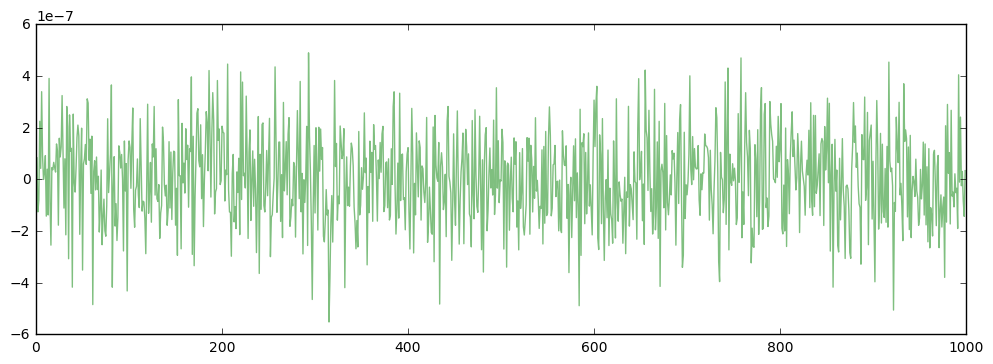

In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,4))

# Plot one run of the sampled data
n1 = [np.random.normal(0, 1.8e-7) + 1.2e-8 * math.sin(float(i) / 100) for i in range(1000)]
plt.plot(n1, color='g', alpha=0.5)

# Show the plot
plt.show()

Much better!  The signal we are measuring has now been compensated for the *correlated* noise that made our RMS calculations wrong.  Now that we removed it we can use the measurements to best estimate the noise of the device under test.

In the case of the Audio Precision graph for Lilienfeld's Choir, the magnitude of the 60Hz and 180Hz overtone are similar to this example case in that they are of similar total magnitude to the actual noise.  While we don't have sample data from the AP test, we can infer that given this knowledge the actual *uncorrelated* noise was roughly half of the reported RMS, or somewhere around 0.8uV RMS, which is at the fringe of the measurement abilities of the AP equipment.  The 60Hz and 180Hz overtone most likely are lead pickup since in other tests this has not been present.  This can be compensated if we have the signal data to uncover the actual thermal noise.  This gives you a measured noise density of approximately 5.6nV/√Hz.  This is pretty good for a power amplifier, as it is only roughly 24dB higher that the noise of some of the world's best phono preamps (an example being the Pass Lab's [Xs Phono](https://passlabs.com/sites/default/files/pass_product_brochure_15.pdf)).  Now that we actually know what the noise of our amplifier is, we can start trying to understand how to make the noise lower.  Is it a byproduct of the topology of the amplifier, the component selection, the environment we put the amplifer into, etc.